# Imports

In [1]:
from IPython.display import Image
from IPython.core.display import HTML

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option("display.precision", 2)
pd.set_option('display.max_columns', None)

import os
os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"
import pydotplus

import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz

import warnings
warnings.filterwarnings('ignore')

# Initial Data Analysis

In [2]:
df = pd.read_csv('heart disease classification dataset.csv')
df = df.drop('Unnamed: 0', 1)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,male,3,145.0,233.0,1,0,150.0,0,2.3,0,0,1,yes
1,37,male,2,130.0,250.0,0,1,187.0,0,3.5,0,0,2,yes
2,41,female,1,130.0,204.0,0,0,172.0,0,1.4,2,0,2,yes
3,56,male,1,120.0,236.0,0,1,178.0,0,0.8,2,0,2,yes
4,57,female,0,NaN,354.0,0,1,163.0,1,0.6,2,0,2,yes


## Attributes

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    object 
 2   cp        303 non-null    int64  
 3   trestbps  299 non-null    float64
 4   chol      302 non-null    float64
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   298 non-null    float64
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    object 
dtypes: float64(4), int64(8), object(2)
memory usage: 33.3+ KB


In [4]:
print(list(df.columns)) 

['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']


In [5]:
df.describe()

,age,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
count,303.00,303.00,299.00,302.00,303.00,303.00,298.00,303.00,303.00,303.00,303.00,303.00
mean,54.37,0.97,131.71,246.32,0.15,0.53,149.87,0.33,1.04,1.40,0.73,2.31
std,9.08,1.03,17.63,51.91,0.36,0.53,22.56,0.47,1.16,0.62,1.02,0.61
min,29.00,0.00,94.00,126.00,0.00,0.00,71.00,0.00,0.00,0.00,0.00,0.00
25%,47.50,0.00,120.00,211.00,0.00,0.00,134.50,0.00,0.00,1.00,0.00,2.00
50%,55.00,1.00,130.00,240.50,0.00,1.00,152.50,0.00,0.80,1.00,0.00,2.00
75%,61.00,2.00,140.00,274.75,0.00,1.00,166.00,1.00,1.60,2.00,1.00,3.00
max,77.00,3.00,200.00,564.00,1.00,2.00,202.00,1.00,6.20,2.00,4.00,3.00


In [6]:
df.shape

(303, 14)

## Missing Data

In [7]:
pd.isna(df).sum()

age         0
sex         0
cp          0
trestbps    4
chol        1
fbs         0
restecg     0
thalach     5
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

## Correlation

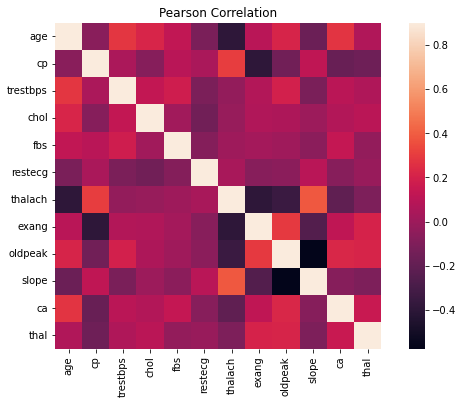

In [8]:
#heatmap correlation
plt.figure(figsize = (10,6))
sns.heatmap(df.corr(), vmax = 0.9, square = True)
plt.title("Pearson Correlation")
plt.savefig('Correlation Heatmap.png', facecolor='white', transparent=False)
plt.show()

## Pairplots

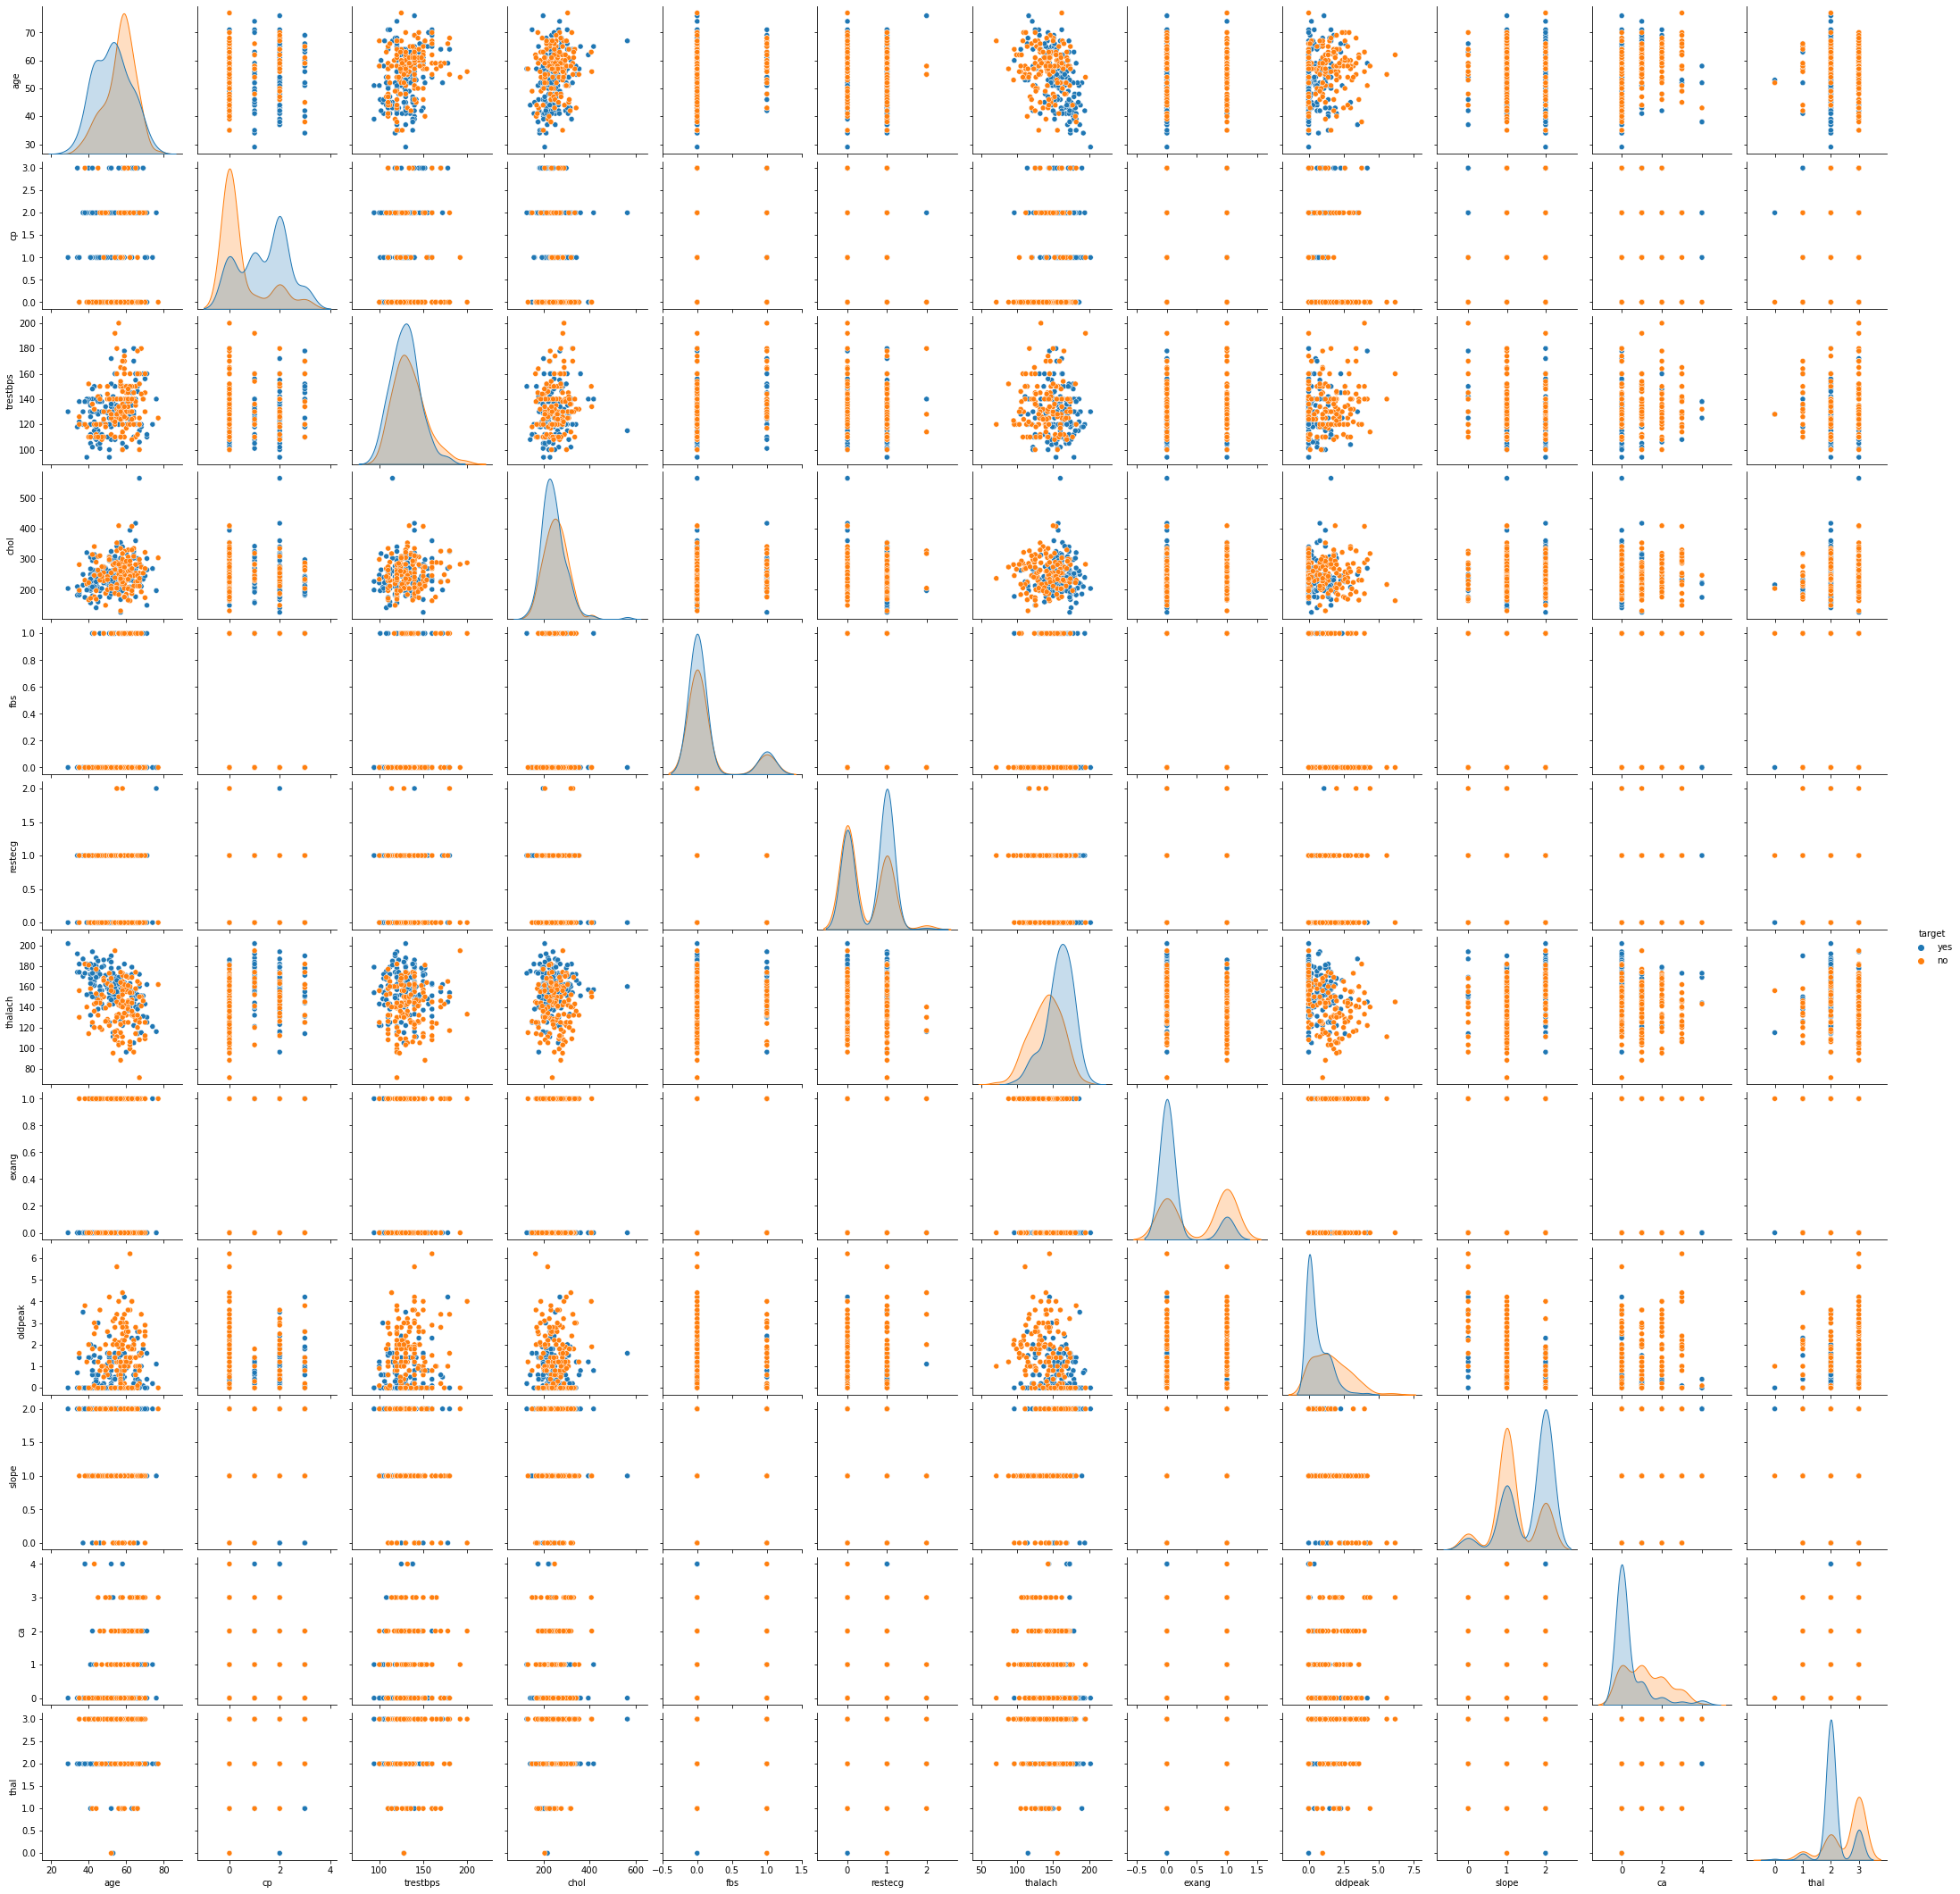

In [9]:
pair_plot_df = df.copy(True)
pair_plot_df.drop(columns=['target'])
sns.pairplot(pair_plot_df, hue= 'target')

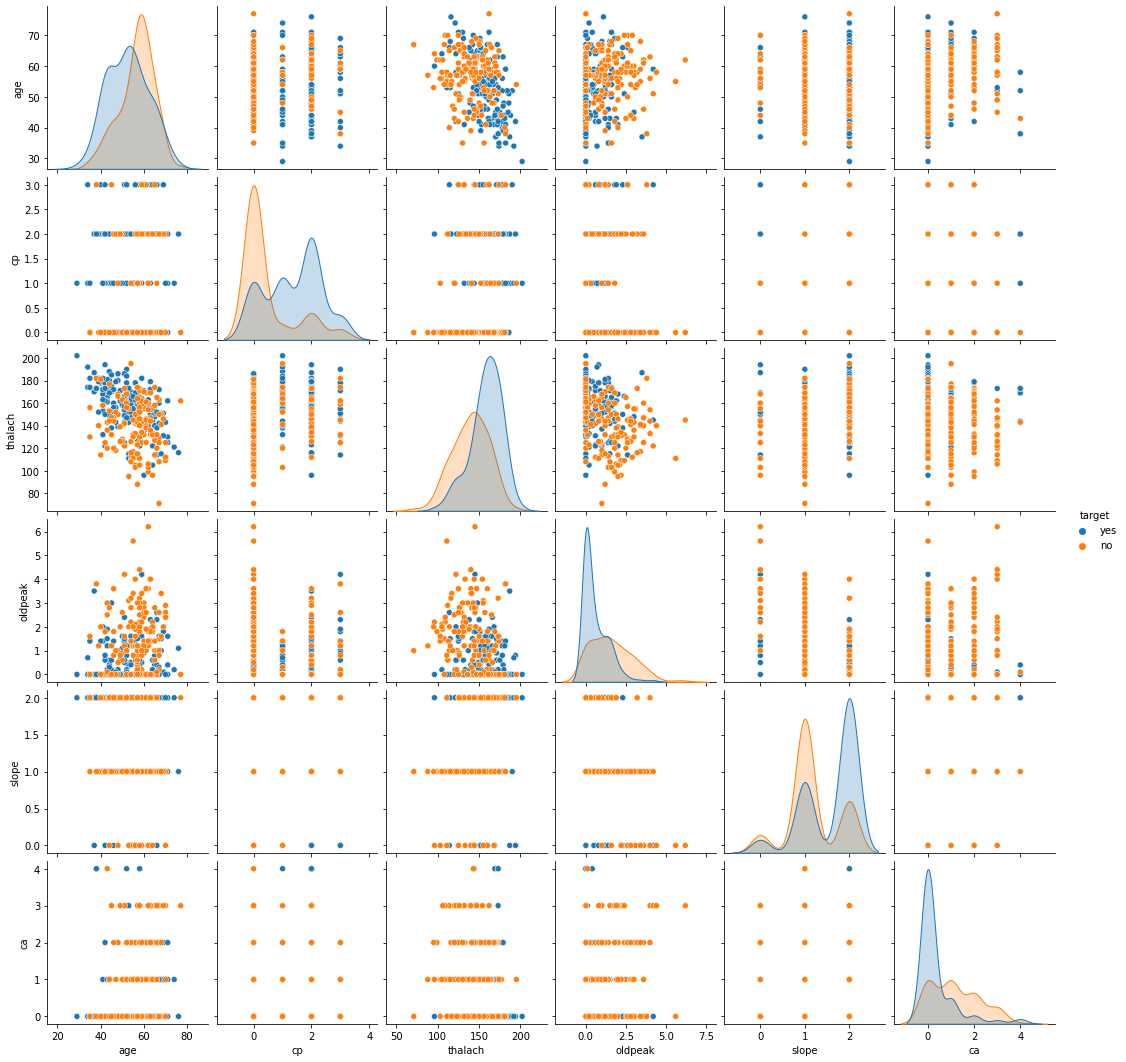

In [10]:
sns.pairplot(df[['age', 'cp', 'thalach', 'oldpeak', 'slope', 'ca', 'target']], hue='target')
plt.savefig('Pairplot- some attributes.png', facecolor='white', transparent=False)

## Class Imbalances

In [11]:
df['target'].value_counts()

yes    165
no     138
Name: target, dtype: int64

# Data Preprocessing

In [12]:
df.dropna(inplace = True)

In [13]:
#transform categorical variable
df['sex'] = df['sex'].astype('category')
df['target'] = df['target'].astype('category')

In [14]:
#handling categorical data
df = pd.DataFrame(df)
df['sex'] = df['sex'].cat.codes
df['target'] = df['target'].cat.codes

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145.0,233.0,1,0,150.0,0,2.3,0,0,1,1
1,37,1,2,130.0,250.0,0,1,187.0,0,3.5,0,0,2,1
2,41,0,1,130.0,204.0,0,0,172.0,0,1.4,2,0,2,1
3,56,1,1,120.0,236.0,0,1,178.0,0,0.8,2,0,2,1
5,57,1,0,140.0,192.0,0,1,148.0,0,0.4,1,0,1,1


In [15]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145.0,233.0,1,0,150.0,0,2.3,0,0,1,1
1,37,1,2,130.0,250.0,0,1,187.0,0,3.5,0,0,2,1
2,41,0,1,130.0,204.0,0,0,172.0,0,1.4,2,0,2,1
3,56,1,1,120.0,236.0,0,1,178.0,0,0.8,2,0,2,1
5,57,1,0,140.0,192.0,0,1,148.0,0,0.4,1,0,1,1


# Train Test Split

In [16]:
RANDOM_SEED = 5

In [17]:
X = df.drop('target', axis = 1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = RANDOM_SEED)

In [18]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(205, 13)
(205,)
(88, 13)
(88,)


# PCA- Visualizing Train/Test Data

In [19]:
pca = PCA(n_components=2, random_state= RANDOM_SEED).fit(X)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

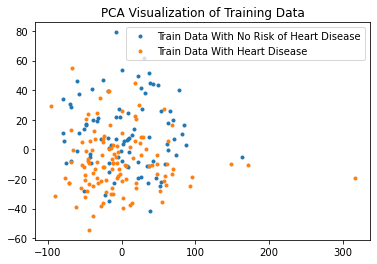

In [20]:
plt.plot(X_train_pca[y_train==0][:,0], X_train_pca[y_train==0][:,1], '.', label= 'Train Data With No Risk of Heart Disease')
plt.plot(X_train_pca[y_train==1][:,0], X_train_pca[y_train==1][:,1], '.', label= 'Train Data With Heart Disease')
plt.legend()
plt.title('PCA Visualization of Training Data')
plt.savefig('PCA Visualization of Training Data.png')
plt.show()

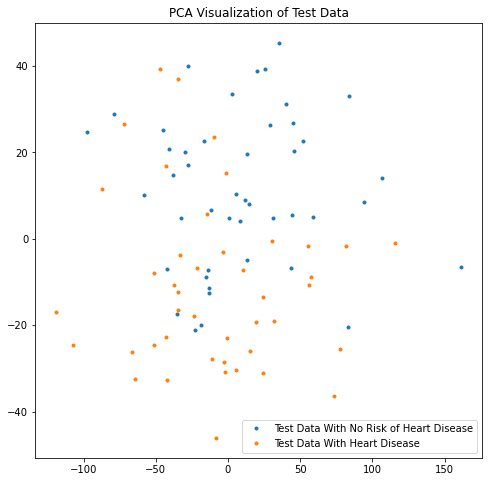

In [21]:
fig = plt.figure(figsize=(8, 8))
plt.plot(X_test_pca[y_test==0][:,0], X_test_pca[y_test==0][:,1], '.', label= 'Test Data With No Risk of Heart Disease')
plt.plot(X_test_pca[y_test==1][:,0], X_test_pca[y_test==1][:,1], '.', label= 'Test Data With Heart Disease')
plt.legend()
plt.title('PCA Visualization of Test Data')
plt.savefig('PCA Visualization of Test Data.png')
plt.show()

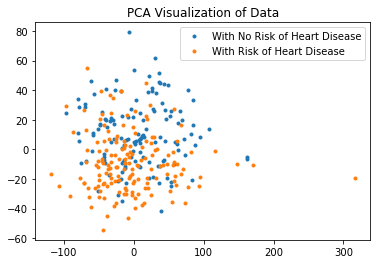

In [22]:
plt.plot(np.concatenate((np.array(X_train_pca[y_train==0][:,0]), np.array(X_test_pca[y_test==0][:,0]))), np.concatenate((np.array(X_train_pca[y_train==0][:,1]), np.array(X_test_pca[y_test==0][:,1]))), '.', label= 'With No Risk of Heart Disease')


plt.plot(np.concatenate((np.array(X_train_pca[y_train==1][:,0]), np.array(X_test_pca[y_test==1][:,0]))), np.concatenate((np.array(X_train_pca[y_train==1][:,1]), np.array(X_test_pca[y_test==1][:,1]))), '.', label= 'With Risk of Heart Disease')

plt.legend()
plt.title('PCA Visualization of Data')
plt.savefig('PCA Visualization of All Data.png', facecolor='white', transparent=False)
plt.show()

# Base Classifiers

In [23]:
classifiers = [
    KNeighborsClassifier(n_neighbors = 5),
    SVC(kernel = 'linear', gamma = 'auto', C = 5, probability = True, random_state= RANDOM_SEED),
    DecisionTreeClassifier(max_depth = 3, random_state= RANDOM_SEED),
    GaussianNB(),
    MultinomialNB()
]

In [24]:
strat_k_fold = StratifiedKFold(n_splits=10, random_state= RANDOM_SEED, shuffle=True)

base_classifer_performances = []

for clf in classifiers:
    clf.fit(X_train, y_train) # get the best one?
    name = clf.__class__.__name__
    test_predictions = clf.predict(X_test)
    cross_val_scores = cross_val_score(clf, X, y, cv=strat_k_fold, scoring='accuracy')
    

    print("=" * 30)
    print('****Results****')
    print(name)
    print(f'Average Cross Validation Score: {cross_val_scores.mean()}')

    '''
        Base classifiers elements:
            0: Classifier Name
            1: Classifier with Base Parameters
            2: Test Predictions
            3: All Cross Validation Scores
            4: Average of Cross Validation Scores
    '''
    base_classifer_performances.append((name, clf, test_predictions, cross_val_scores, cross_val_scores.mean()))
    
print("=" * 30)

****Results****
KNeighborsClassifier
Average Cross Validation Score: 0.6342528735632184
****Results****
SVC
Average Cross Validation Score: 0.8364367816091954
****Results****
DecisionTreeClassifier
Average Cross Validation Score: 0.8087356321839081
****Results****
GaussianNB
Average Cross Validation Score: 0.8262068965517241
****Results****
MultinomialNB
Average Cross Validation Score: 0.7474712643678162


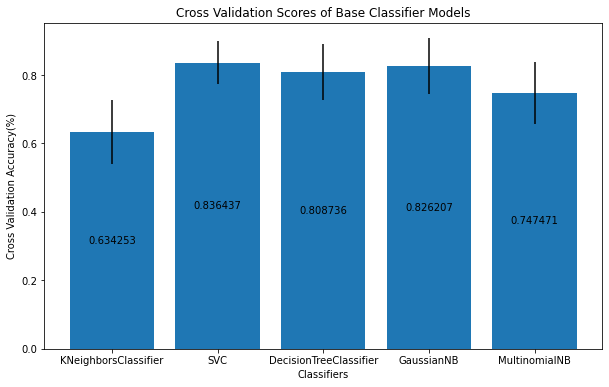

In [25]:
fig = plt.figure(figsize=(10,6))
x_errb = [i for i in range(len(base_classifer_performances))]
y_errb = [base_classifer_performances[i][4] for i in range(len(base_classifer_performances))]
y_errb_err = [base_classifer_performances[i][3].std() for i in range(len(base_classifer_performances))]
bars = plt.bar(x_errb, y_errb, yerr=y_errb_err)
plt.xticks(x_errb, labels=[base_classifer_performances[i][0] for i in range(len(base_classifer_performances))])
plt.bar_label(bars, label_type='center')
plt.ylabel('Cross Validation Accuracy(%)')
plt.xlabel('Classifiers')
plt.title('Cross Validation Scores of Base Classifier Models')
plt.savefig('Base Classifiers Performance.png', facecolor='white', transparent=False)
plt.show()

## PCA Error Visualizations of Each of the Classifiers

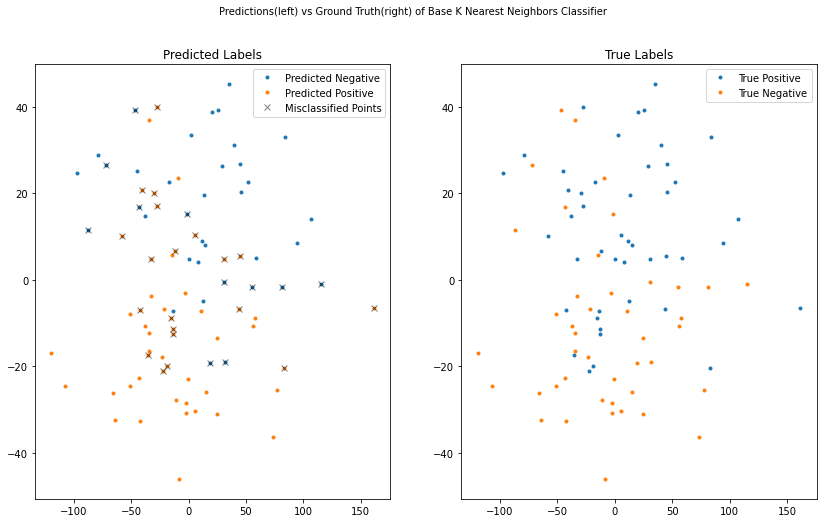

In [26]:
# KNN
plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
plt.plot(X_test_pca[base_classifer_performances[0][2]==0][:,0], X_test_pca[base_classifer_performances[0][2]==0][:,1], '.', label='Predicted Negative')
plt.plot(X_test_pca[base_classifer_performances[0][2]==1][:,0], X_test_pca[base_classifer_performances[0][2]==1][:,1], '.', label='Predicted Positive')
plt.plot(X_test_pca[base_classifer_performances[0][2]!=y_test][:,0], X_test_pca[base_classifer_performances[0][2]!=y_test][:,1], 'x', color='black', alpha=0.5, label='Misclassified Points')
plt.legend()
plt.title('Predicted Labels')
plt.subplot(1,2,2)
plt.plot(X_test_pca[y_test==0][:,0], X_test_pca[y_test==0][:,1], '.', label='True Positive')
plt.plot(X_test_pca[y_test==1][:,0], X_test_pca[y_test==1][:,1], '.', label='True Negative')
plt.legend()
plt.title('True Labels')
plt.suptitle('Predictions(left) vs Ground Truth(right) of Base K Nearest Neighbors Classifier', fontsize= 'medium')
plt.savefig('Base K Nearest Neighbors Ground Truth vs predictions.png', facecolor='white', transparent=False)

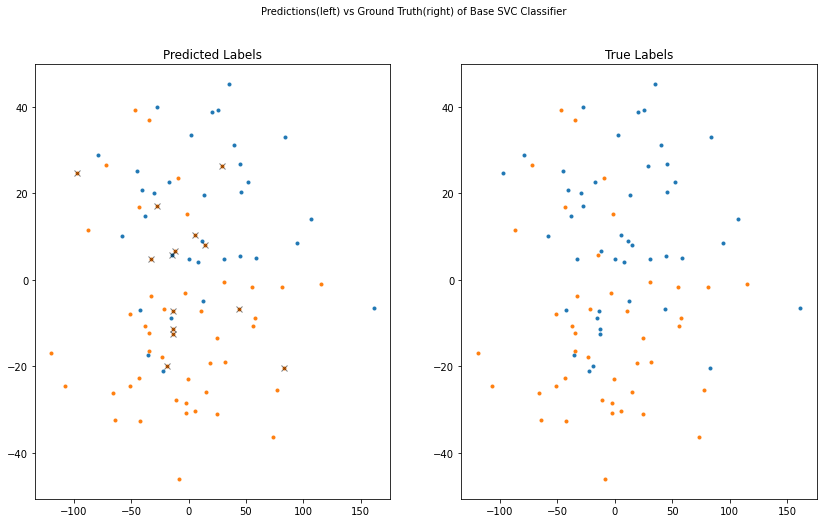

In [27]:
# SVC
plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
plt.plot(X_test_pca[base_classifer_performances[1][2]==0][:,0], X_test_pca[base_classifer_performances[1][2]==0][:,1], '.', label='Predicted Negative')
plt.plot(X_test_pca[base_classifer_performances[1][2]==1][:,0], X_test_pca[base_classifer_performances[1][2]==1][:,1], '.', label='Predicted Positive')
plt.plot(X_test_pca[base_classifer_performances[1][2]!=y_test][:,0], X_test_pca[base_classifer_performances[1][2]!=y_test][:,1], 'x', color='black', alpha=0.5, label='Misclassified Points')
plt.title('Predicted Labels')
plt.subplot(1,2,2)
plt.plot(X_test_pca[y_test==0][:,0], X_test_pca[y_test==0][:,1], '.', label='True Positive')
plt.plot(X_test_pca[y_test==1][:,0], X_test_pca[y_test==1][:,1], '.', label='True Negative')
plt.title('True Labels')
plt.suptitle('Predictions(left) vs Ground Truth(right) of Base SVC Classifier', fontsize= 'medium')
plt.savefig('Base SVC Classifier Ground Truth vs predictions.png', facecolor='white', transparent=False)

In [28]:
def tree_graph_to_png(tree, feature_names, png_file_to_save):
    tree_str = export_graphviz(tree, feature_names=feature_names, filled=True, out_file=None)
    graph = pydotplus.graph_from_dot_data(tree_str)  
    graph.write_png(png_file_to_save)

In [29]:
tree_graph_to_png(classifiers[2], X.columns, 'base_decision_tree.png')

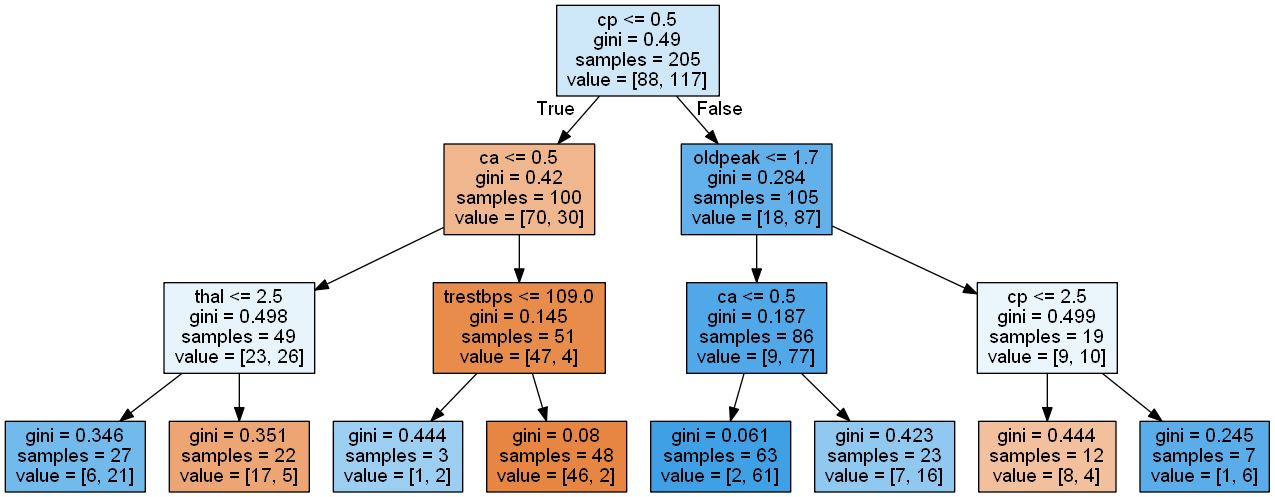

In [30]:
PATH = "base_decision_tree.png"
Image(filename = PATH , width=900, height=600)

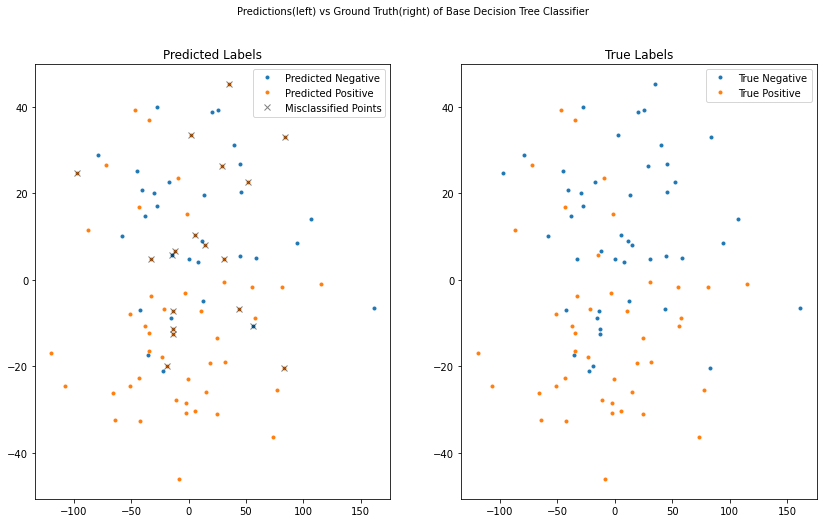

In [31]:
# Decision Trees
plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
plt.plot(X_test_pca[base_classifer_performances[2][2]==0][:,0], X_test_pca[base_classifer_performances[2][2]==0][:,1], '.', label='Predicted Negative')
plt.plot(X_test_pca[base_classifer_performances[2][2]==1][:,0], X_test_pca[base_classifer_performances[2][2]==1][:,1], '.', label='Predicted Positive')
plt.plot(X_test_pca[base_classifer_performances[2][2]!=y_test][:,0], X_test_pca[base_classifer_performances[2][2]!=y_test][:,1], 'x', color='black', alpha=0.5, label='Misclassified Points')
plt.title('Predicted Labels')
plt.legend()
plt.subplot(1,2,2)
plt.plot(X_test_pca[y_test==0][:,0], X_test_pca[y_test==0][:,1], '.', label='True Negative')
plt.plot(X_test_pca[y_test==1][:,0], X_test_pca[y_test==1][:,1], '.', label='True Positive')
plt.title('True Labels')
plt.legend()
plt.suptitle('Predictions(left) vs Ground Truth(right) of Base Decision Tree Classifier', fontsize= 'medium')
plt.savefig('Base Decision Tree Classifier Ground Truth vs predictions.png', facecolor='white', transparent=False)

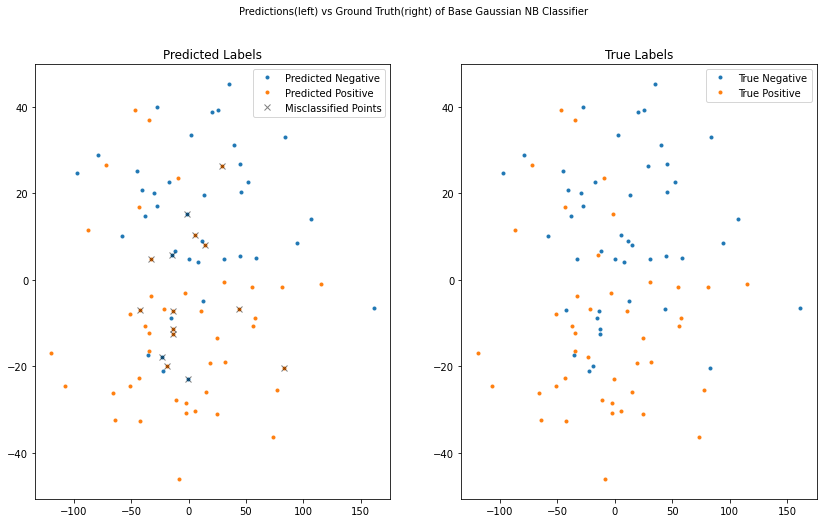

In [32]:
# Gaussian NB
plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
plt.plot(X_test_pca[base_classifer_performances[3][2]==0][:,0], X_test_pca[base_classifer_performances[3][2]==0][:,1], '.', label='Predicted Negative')
plt.plot(X_test_pca[base_classifer_performances[3][2]==1][:,0], X_test_pca[base_classifer_performances[3][2]==1][:,1], '.', label='Predicted Positive')
plt.plot(X_test_pca[base_classifer_performances[3][2]!=y_test][:,0], X_test_pca[base_classifer_performances[3][2]!=y_test][:,1], 'x', color='black', alpha=0.5, label='Misclassified Points')
plt.title('Predicted Labels')
plt.legend()
plt.subplot(1,2,2)
plt.plot(X_test_pca[y_test==0][:,0], X_test_pca[y_test==0][:,1], '.', label='True Negative')
plt.plot(X_test_pca[y_test==1][:,0], X_test_pca[y_test==1][:,1], '.', label='True Positive')
plt.title('True Labels')
plt.legend()
plt.suptitle('Predictions(left) vs Ground Truth(right) of Base Gaussian NB Classifier', fontsize= 'medium')
plt.savefig('Base Gaussian NB Classifier Ground Truth vs predictions.png', facecolor='white', transparent=False)

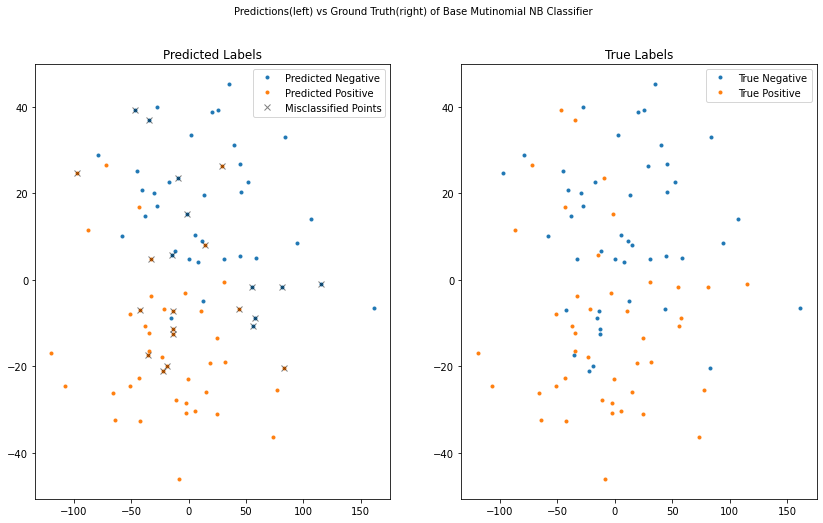

In [33]:
# Multinomial NB
plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
plt.plot(X_test_pca[base_classifer_performances[4][2]==0][:,0], X_test_pca[base_classifer_performances[4][2]==0][:,1], '.', label='Predicted Negative')
plt.plot(X_test_pca[base_classifer_performances[4][2]==1][:,0], X_test_pca[base_classifer_performances[4][2]==1][:,1], '.', label='Predicted Positive')
plt.plot(X_test_pca[base_classifer_performances[4][2]!=y_test][:,0], X_test_pca[base_classifer_performances[4][2]!=y_test][:,1], 'x', color='black', alpha=0.5, label='Misclassified Points')
plt.title('Predicted Labels')
plt.legend()
plt.subplot(1,2,2)
plt.plot(X_test_pca[y_test==0][:,0], X_test_pca[y_test==0][:,1], '.', label='True Negative')
plt.plot(X_test_pca[y_test==1][:,0], X_test_pca[y_test==1][:,1], '.', label='True Positive')
plt.title('True Labels')
plt.legend()
plt.suptitle('Predictions(left) vs Ground Truth(right) of Base Mutinomial NB Classifier', fontsize= 'medium')
plt.savefig('Base Mutinomial NB Classifier Ground Truth vs predictions.png', facecolor='white', transparent=False)

# Hyperparameter Tuning

In [34]:
params = [
    {'n_neighbors': range(5, 16, 2)}, # 5, 7, 9, 11, 13, 15
    {'kernel':['linear', 'rbf', 'sigmoid'], 'C':[0.2, 0.5, 0.75]},
    {'criterion':['gini', 'entropy'], 'max_depth':[None, 15, 10, 5]},
    {'priors': [[0.5,0.5], [0.4, 0.6], [0.6, 0.4]]}, # potentially do an unbiased (.value_counts() ratios of target in your training set, [.4, .6])
    {'alpha':[0, 0.5, 1]}
]


In [35]:
strat_k_fold = StratifiedKFold(n_splits=10, random_state= RANDOM_SEED, shuffle=True)

best_classifers_performance = []
predictions = []

for i, myclf in enumerate(classifiers):
    clf = GridSearchCV(myclf, params[i], cv=5, n_jobs=-1, verbose=True)
    clf.fit(X_train, y_train)
    name = myclf.__class__.__name__
    test_predictions = clf.predict(X_test)
    predictions.append(test_predictions)

    print("=" * 30)
    print('****Results****')
    print(clf.best_params_)
    cross_val_scores = cross_val_score(clf, X, y, cv=strat_k_fold, scoring='accuracy')
    print(f'Average Cross Validation Score: {cross_val_scores.mean()}')
    
    '''
        Best classifiers elements:
            0: Classifier Name
            1: Best Parameters of Classifier
            2: Classifer with Best Parameters
            3: Test Predictions
            4: All Cross Validation Scores
            5: Average of Cross Validation Scores
    '''
    best_classifers_performance.append((name, clf.best_params_, clf.best_estimator_, test_predictions, cross_val_scores, cross_val_scores.mean()))

    
print("=" * 30)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
****Results****
{'n_neighbors': 11}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Average Cross Validation Score: 0.6339080459770116
Fitting 5 folds for each of 9 candidates, totalling 45 fits
****Results****
{'C': 0.75, 'kernel': 'linear'}
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each 

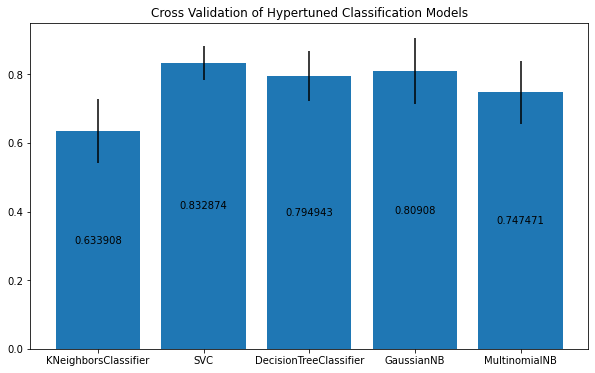

In [36]:
#visualize accuracy models
plt.figure(figsize = (10,6))
bars = sns.barplot(x = [best_classifers_performance[i][0] for i in range(len(best_classifers_performance))], y = [best_classifers_performance[i][5] for i in range(len(best_classifers_performance))], color = "blue")
x_errb = [i for i in range(len(best_classifers_performance))]
y_errb = [best_classifers_performance[i][5] for i in range(len(best_classifers_performance))]
y_errb_err = [best_classifers_performance[i][4].std() for i in range(len(best_classifers_performance))]
bars = plt.bar(x_errb, y_errb, yerr=y_errb_err)
plt.xticks(x_errb, labels=[best_classifers_performance[i][0] for i in range(len(best_classifers_performance))])
plt.bar_label(bars, label_type='center')

plt.title('Cross Validation of Hypertuned Classification Models')
plt.savefig('Best Classifiers Performance.png', facecolor='white', transparent=False)
plt.show()

## PCA Error Visualizations of Each of the Classifiers

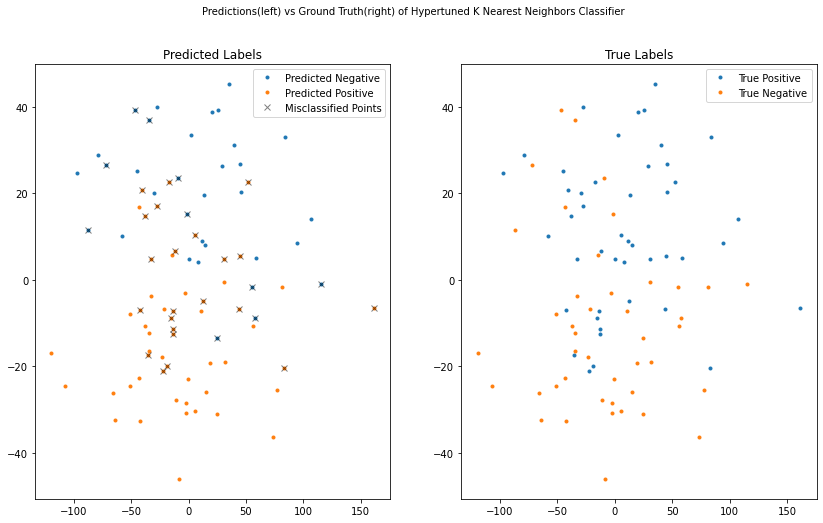

In [37]:
# KNN
plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
plt.plot(X_test_pca[best_classifers_performance[0][3]==0][:,0], X_test_pca[best_classifers_performance[0][3]==0][:,1], '.', label='Predicted Negative')
plt.plot(X_test_pca[best_classifers_performance[0][3]==1][:,0], X_test_pca[best_classifers_performance[0][3]==1][:,1], '.', label='Predicted Positive')
plt.plot(X_test_pca[best_classifers_performance[0][3]!=y_test][:,0], X_test_pca[best_classifers_performance[0][3]!=y_test][:,1], 'x', color='black', alpha=0.5, label='Misclassified Points')
plt.legend()
plt.title('Predicted Labels')
plt.subplot(1,2,2)
plt.plot(X_test_pca[y_test==0][:,0], X_test_pca[y_test==0][:,1], '.', label='True Positive')
plt.plot(X_test_pca[y_test==1][:,0], X_test_pca[y_test==1][:,1], '.', label='True Negative')
plt.legend()
plt.title('True Labels')
plt.suptitle('Predictions(left) vs Ground Truth(right) of Hypertuned K Nearest Neighbors Classifier', fontsize= 'medium')
plt.savefig('Predictions(left) vs Ground Truth(right) of Hypertuned K Nearest Neighbors Classifier.png', facecolor='white', transparent=False)

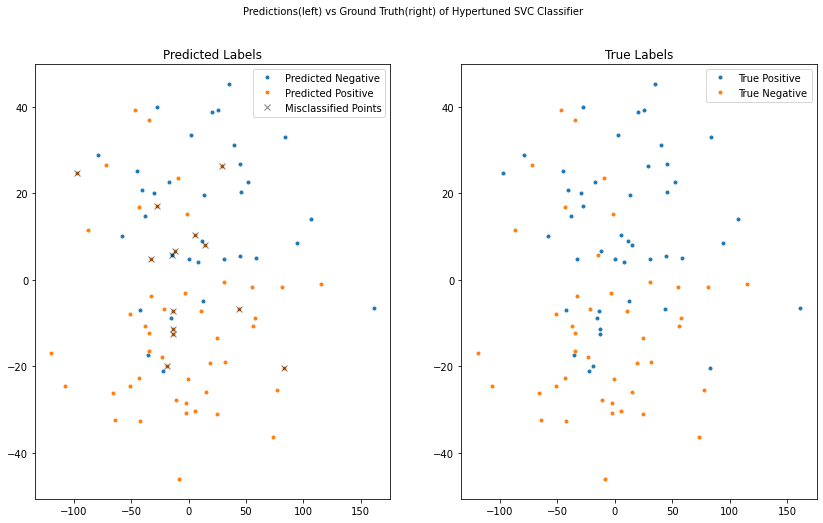

In [38]:
# SVC
plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
plt.plot(X_test_pca[predictions[1]==0][:,0], X_test_pca[predictions[1]==0][:,1], '.', label='Predicted Negative')
plt.plot(X_test_pca[predictions[1]==1][:,0], X_test_pca[predictions[1]==1][:,1], '.', label='Predicted Positive')
plt.plot(X_test_pca[predictions[1]!=y_test][:,0], X_test_pca[predictions[1]!=y_test][:,1], 'x', color='black', alpha=0.5, label='Misclassified Points')
plt.legend()
plt.title('Predicted Labels')
plt.subplot(1,2,2)
plt.plot(X_test_pca[y_test==0][:,0], X_test_pca[y_test==0][:,1], '.', label='True Positive')
plt.plot(X_test_pca[y_test==1][:,0], X_test_pca[y_test==1][:,1], '.', label='True Negative')
plt.legend()
plt.title('True Labels')
plt.suptitle('Predictions(left) vs Ground Truth(right) of Hypertuned SVC Classifier', fontsize= 'medium')
plt.savefig('Predictions(left) vs Ground Truth(right) of Hypertuned SVC Classifier.png', facecolor='white', transparent=False)

In [39]:
tree_graph_to_png(best_classifers_performance[2][2], X.columns, 'best_decision_tree.png')

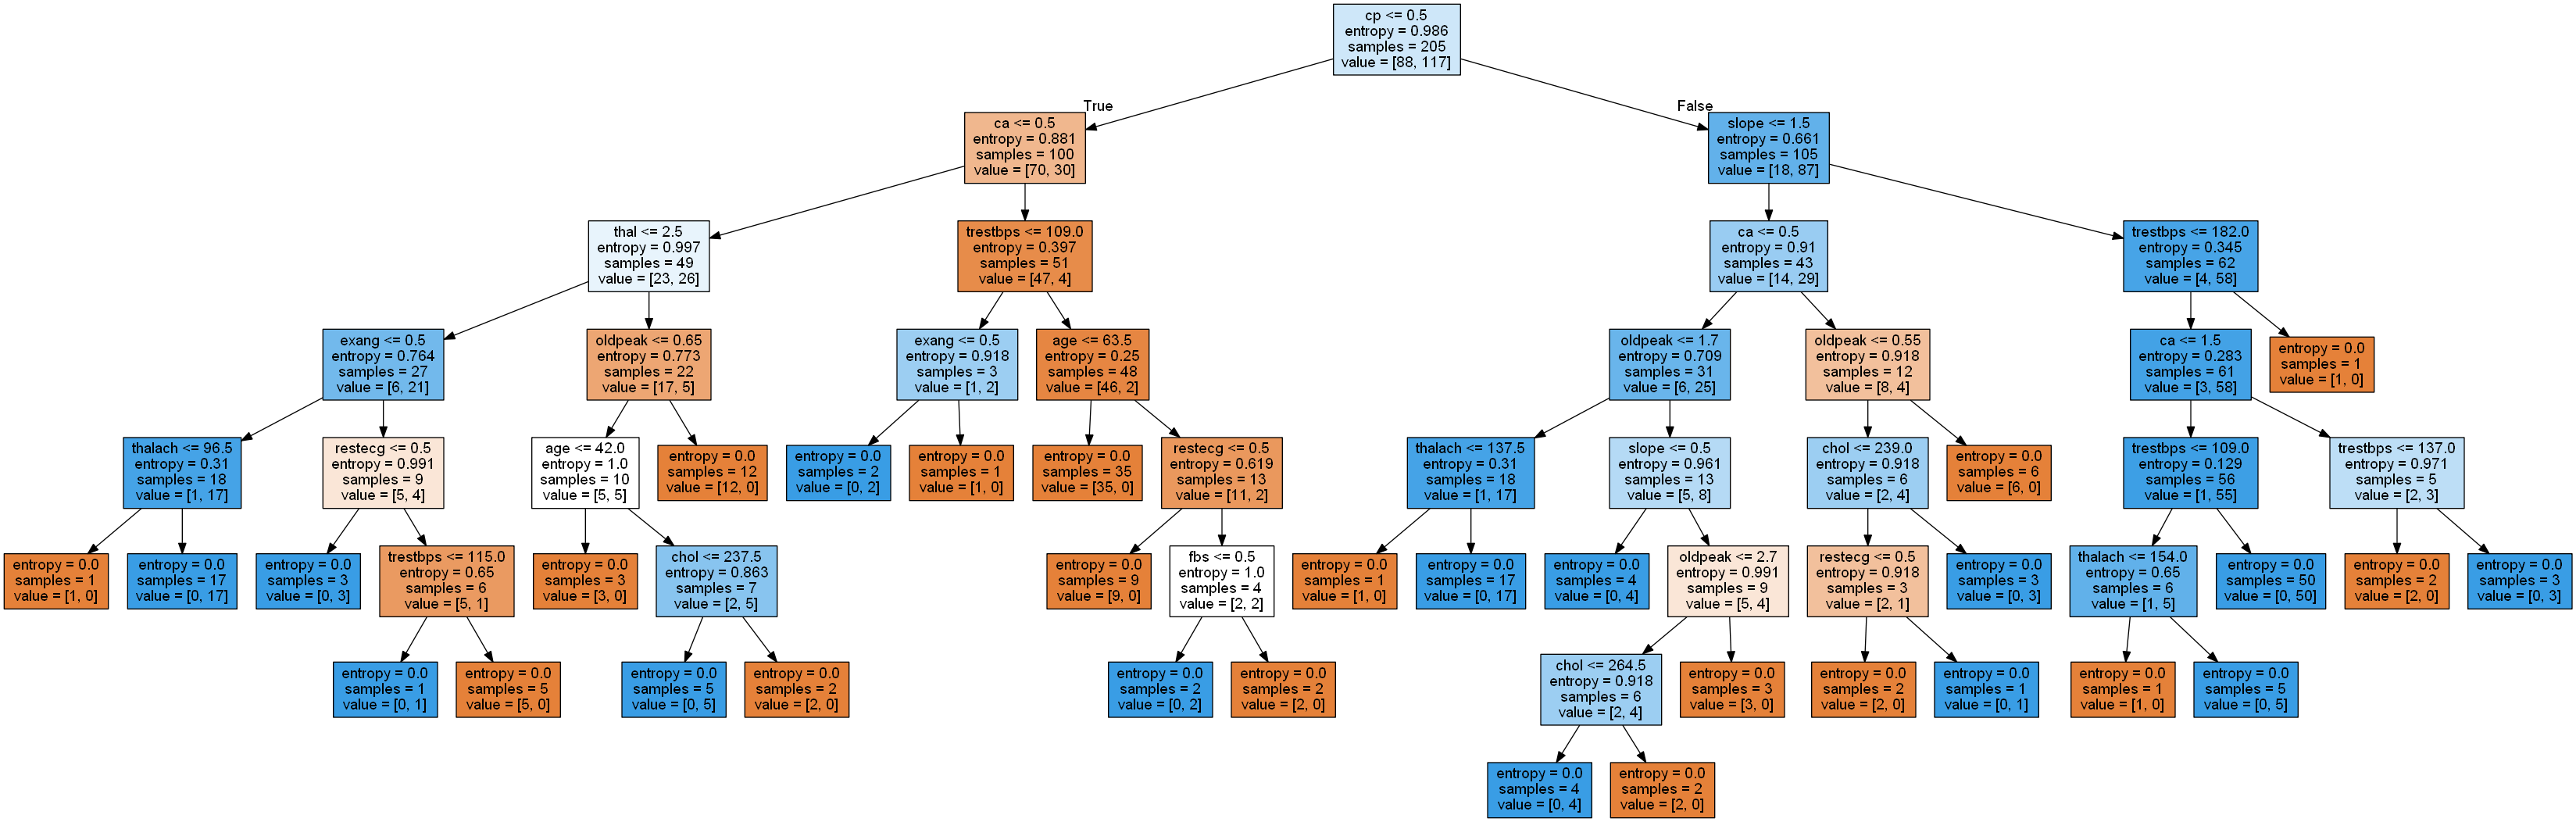

In [40]:
PATH = "best_decision_tree.png"
Image(filename = PATH , width=900, height=600)

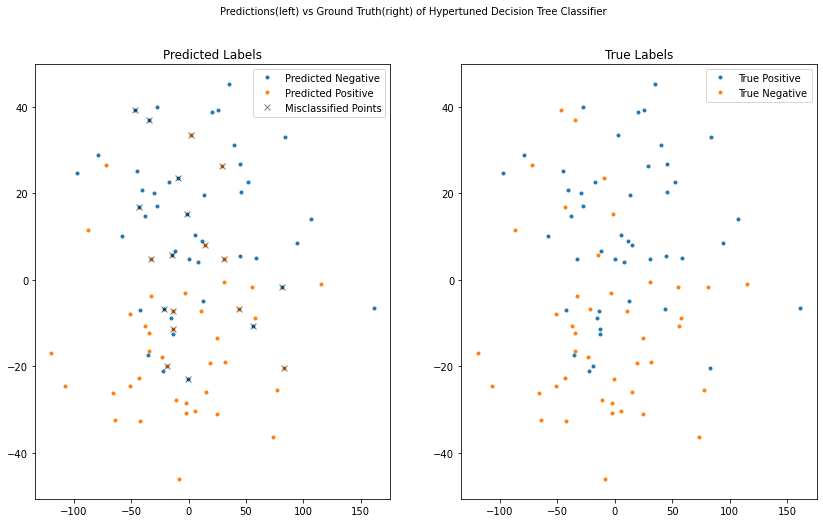

In [41]:
# Decision Trees
plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
plt.plot(X_test_pca[predictions[2]==0][:,0], X_test_pca[predictions[2]==0][:,1], '.', label='Predicted Negative')
plt.plot(X_test_pca[predictions[2]==1][:,0], X_test_pca[predictions[2]==1][:,1], '.', label='Predicted Positive')
plt.plot(X_test_pca[predictions[2]!=y_test][:,0], X_test_pca[predictions[2]!=y_test][:,1], 'x', color='black', alpha=0.5, label='Misclassified Points')
plt.legend()
plt.title('Predicted Labels')
plt.subplot(1,2,2)
plt.plot(X_test_pca[y_test==0][:,0], X_test_pca[y_test==0][:,1], '.', label='True Positive')
plt.plot(X_test_pca[y_test==1][:,0], X_test_pca[y_test==1][:,1], '.', label='True Negative')
plt.legend()
plt.title('True Labels')
plt.suptitle('Predictions(left) vs Ground Truth(right) of Hypertuned Decision Tree Classifier', fontsize= 'medium')
plt.savefig('Predictions(left) vs Ground Truth(right) of Hypertuned Decision Tree Classifier.png', facecolor='white', transparent=False)

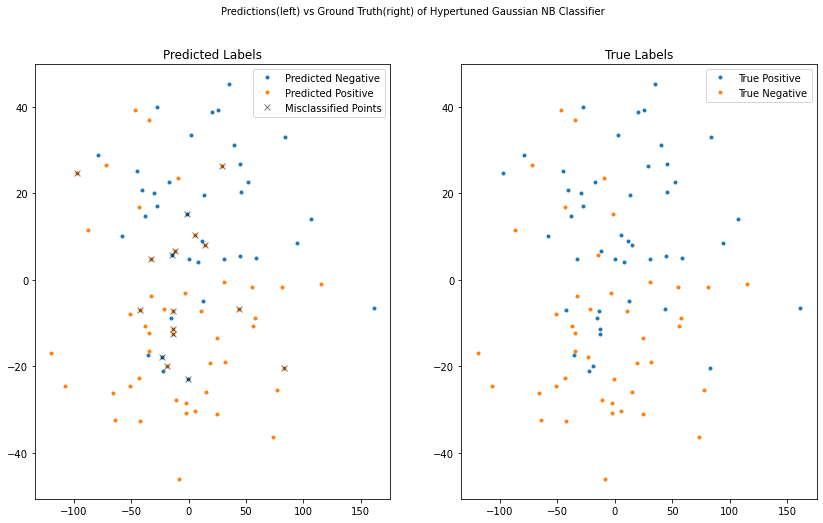

In [42]:
# Gaussian NB
plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
plt.plot(X_test_pca[predictions[3]==0][:,0], X_test_pca[predictions[3]==0][:,1], '.', label='Predicted Negative')
plt.plot(X_test_pca[predictions[3]==1][:,0], X_test_pca[predictions[3]==1][:,1], '.', label='Predicted Positive')
plt.plot(X_test_pca[predictions[3]!=y_test][:,0], X_test_pca[predictions[3]!=y_test][:,1], 'x', color='black', alpha=0.5, label='Misclassified Points')
plt.legend()
plt.title('Predicted Labels')
plt.subplot(1,2,2)
plt.plot(X_test_pca[y_test==0][:,0], X_test_pca[y_test==0][:,1], '.', label='True Positive')
plt.plot(X_test_pca[y_test==1][:,0], X_test_pca[y_test==1][:,1], '.', label='True Negative')
plt.legend()
plt.title('True Labels')
plt.suptitle('Predictions(left) vs Ground Truth(right) of Hypertuned Gaussian NB Classifier', fontsize= 'medium')
plt.savefig('Predictions(left) vs Ground Truth(right) of Hypertuned Gaussian NB Classifier.png', facecolor='white', transparent=False)

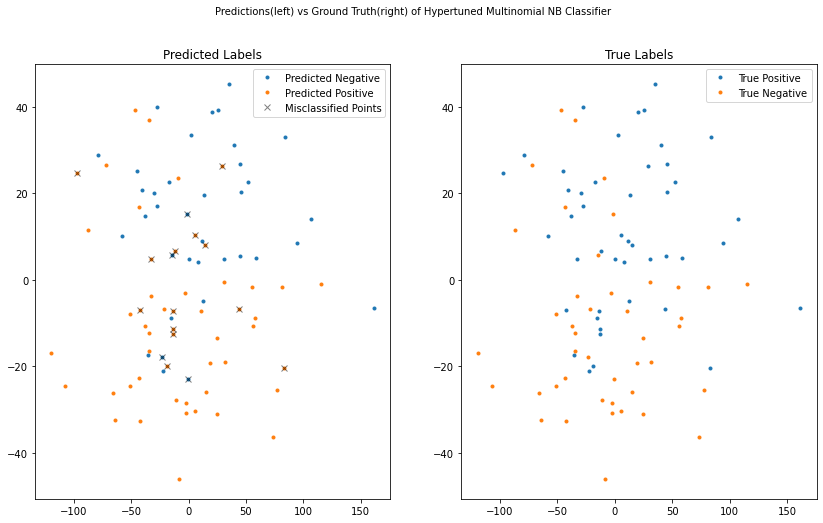

In [43]:
# Multinomial NB
plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
plt.plot(X_test_pca[predictions[3]==0][:,0], X_test_pca[predictions[3]==0][:,1], '.', label='Predicted Negative')
plt.plot(X_test_pca[predictions[3]==1][:,0], X_test_pca[predictions[3]==1][:,1], '.', label='Predicted Positive')
plt.plot(X_test_pca[predictions[3]!=y_test][:,0], X_test_pca[predictions[3]!=y_test][:,1], 'x', color='black', alpha=0.5, label='Misclassified Points')
plt.legend()
plt.title('Predicted Labels')
plt.subplot(1,2,2)
plt.plot(X_test_pca[y_test==0][:,0], X_test_pca[y_test==0][:,1], '.', label='True Positive')
plt.plot(X_test_pca[y_test==1][:,0], X_test_pca[y_test==1][:,1], '.', label='True Negative')
plt.legend()
plt.title('True Labels')
plt.suptitle('Predictions(left) vs Ground Truth(right) of Hypertuned Multinomial NB Classifier', fontsize= 'medium')
plt.savefig('Predictions(left) vs Ground Truth(right) of Hypertuned Multinomial NB Classifier.png', facecolor='white', transparent=False)

# Confusion Matrices

## Base Classifiers

<Figure size 720x432 with 0 Axes>

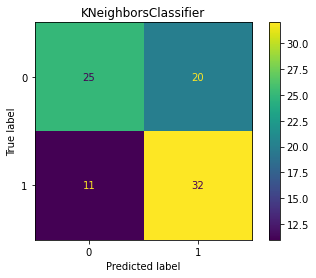

<Figure size 720x432 with 0 Axes>

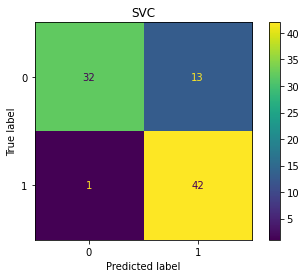

<Figure size 720x432 with 0 Axes>

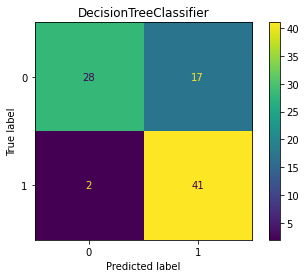

<Figure size 720x432 with 0 Axes>

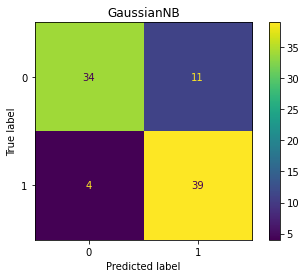

<Figure size 720x432 with 0 Axes>

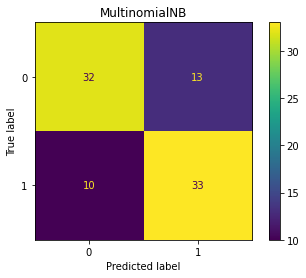

In [44]:
for i in range(len(base_classifer_performances)):
    plt.figure(figsize=(10,6))
    matrix = confusion_matrix(base_classifer_performances[i][2], y_test)
    plot_confusion_matrix(classifiers[i], X_test, y_test)  
    plt.title(base_classifer_performances[i][0])
    plt.savefig(f'Base {base_classifer_performances[i][0]} Confusion Matrix.png', facecolor='white', transparent=False)
    plt.show()

## Hypertuned Classifiers

<Figure size 720x432 with 0 Axes>

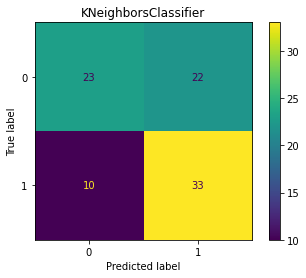

<Figure size 720x432 with 0 Axes>

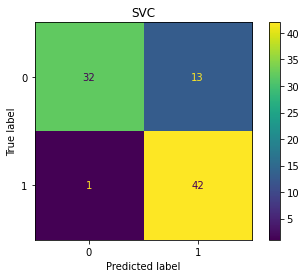

<Figure size 720x432 with 0 Axes>

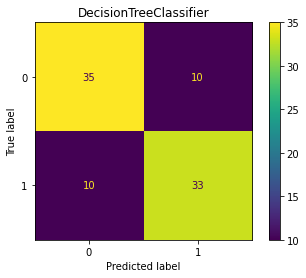

<Figure size 720x432 with 0 Axes>

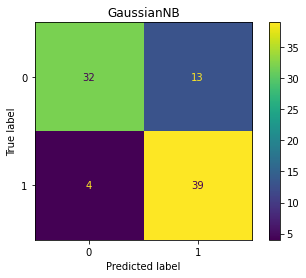

<Figure size 720x432 with 0 Axes>

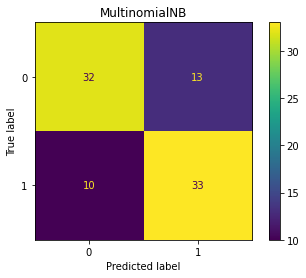

In [45]:
for i in range(len(best_classifers_performance)):
    plt.figure(figsize=(10,6))
    plot_confusion_matrix(best_classifers_performance[i][2], X_test, y_test)  
    plt.title(best_classifers_performance[i][0])
    plt.savefig(f'Best {best_classifers_performance[i][0]} Confusion Matrix.png', facecolor='white', transparent=False)
    plt.show()

## ROC Curves

In [46]:
base_classifer_performances

[('KNeighborsClassifier',
  KNeighborsClassifier(),
  array([0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0,
         0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1,
         1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1,
         1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1],
        dtype=int8),
  array([0.63333333, 0.86666667, 0.56666667, 0.65517241, 0.72413793,
         0.5862069 , 0.5862069 , 0.5862069 , 0.51724138, 0.62068966]),
  0.6342528735632184),
 ('SVC',
  SVC(C=5, gamma='auto', kernel='linear', probability=True, random_state=5),
  array([1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
         0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
         1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1],
        dtype=int8),
  array([0.83333333, 0.73333333, 0.86666667, 0.86206897

In [47]:
best_classifers_performance

[('KNeighborsClassifier',
  {'n_neighbors': 11},
  KNeighborsClassifier(n_neighbors=11),
  array([0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
         0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
         1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
         1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        dtype=int8),
  array([0.63333333, 0.86666667, 0.66666667, 0.65517241, 0.68965517,
         0.5862069 , 0.5862069 , 0.5862069 , 0.51724138, 0.55172414]),
  0.6339080459770116),
 ('SVC',
  {'C': 0.75, 'kernel': 'linear'},
  SVC(C=0.75, gamma='auto', kernel='linear', probability=True, random_state=5),
  array([1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
         0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
         1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1],
 

## Base Classifiers

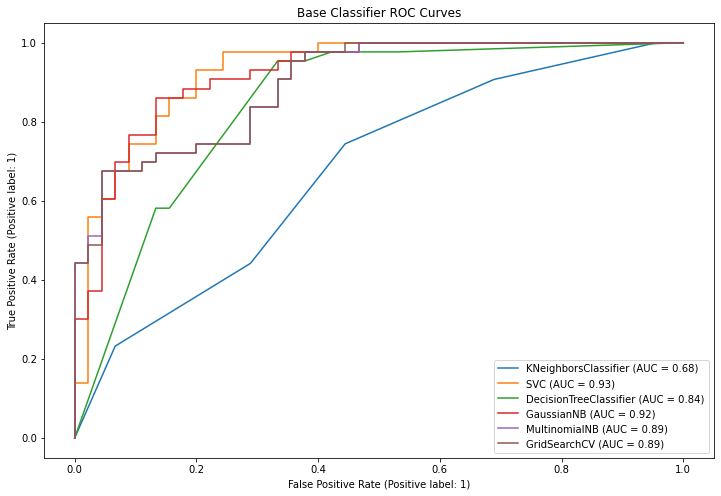

In [48]:
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots(1, 1, figsize=(12,8))
plt.title('Base Classifier ROC Curves')
rcd = RocCurveDisplay
for i in range(len(base_classifer_performances)):
    rcd.from_estimator(base_classifer_performances[i][1], X_test, y_test, ax=ax)

rcd.from_estimator(clf, X_test, y_test, ax=ax)
plt.savefig('Best Classifiers ROC Curve.png', facecolor='white', transparent=False)


## Hypertuned Classifiers

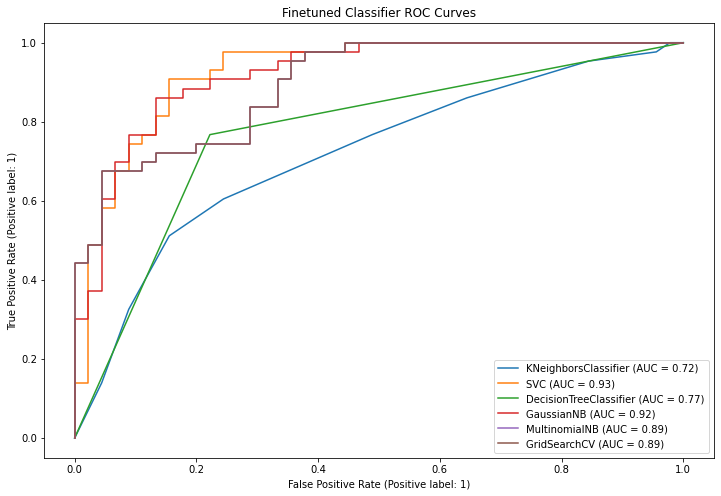

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
plt.title('Finetuned Classifier ROC Curves')
rcd = RocCurveDisplay
for i in range(len(best_classifers_performance)):
    rcd.from_estimator(best_classifers_performance[i][2], X_test, y_test, ax=ax)

rcd.from_estimator(clf, X_test, y_test, ax=ax)
plt.savefig('Best Classifiers ROC.png', facecolor='white', transparent=False)

# Random Forest Classifer

In [50]:
params = {'n_estimators': [70, 75, 80, 85, 90]}

myclf = RandomForestClassifier(random_state= RANDOM_SEED)

clf = GridSearchCV(myclf, params, cv=5, n_jobs=-1, verbose=True)
name = myclf.__class__.__name__
clf.fit(X_train, y_train) # get the best one?
y_pred = clf.predict(X_test)
print('****Results****')
print(name)
print(clf.best_params_)
cross_val_scores = cross_val_score(clf, X, y, cv=strat_k_fold, scoring='accuracy')
print(f'Average Cross Validation Score: {cross_val_scores.mean()}')

'''
    Best classifiers elements:
        0: Classifier Name
        1: Best Parameters of Classifier
        2: Classifer with Best Parameters
        3: Test Predictions
        4: All Cross Validation Scores
        5: Average of Cross Validation Scores
'''
best_classifers_performance.append((name, clf.best_params_, clf.best_estimator_, test_predictions, cross_val_scores, cross_val_scores.mean()))


Fitting 5 folds for each of 5 candidates, totalling 25 fits
****Results****
RandomForestClassifier
{'n_estimators': 70}
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Average Cross Validation Score: 0.8224137931034482


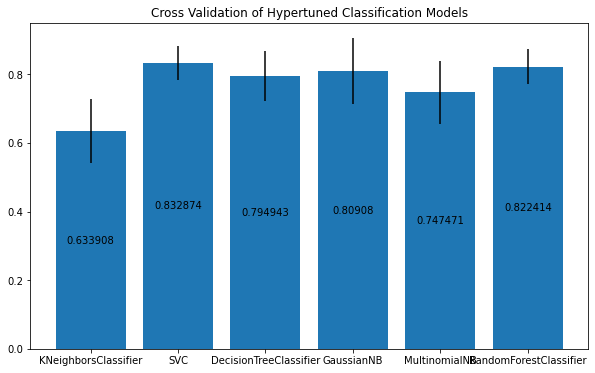

In [57]:
#visualize accuracy models
plt.figure(figsize = (10,6))
bars = sns.barplot(x = [best_classifers_performance[i][0] for i in range(len(best_classifers_performance))], y = [best_classifers_performance[i][5] for i in range(len(best_classifers_performance))], color = "blue")
x_errb = [i for i in range(len(best_classifers_performance))]
y_errb = [best_classifers_performance[i][5] for i in range(len(best_classifers_performance))]
y_errb_err = [best_classifers_performance[i][4].std() for i in range(len(best_classifers_performance))]
bars = plt.bar(x_errb, y_errb, yerr=y_errb_err)
plt.xticks(x_errb, labels=[best_classifers_performance[i][0] for i in range(len(best_classifers_performance))])
plt.bar_label(bars, label_type='center')

plt.title('Cross Validation of Hypertuned Classification Models')
plt.savefig('Best Classifiers Performance with Random Forest.png', facecolor='white', transparent=False)
plt.show()

Text(0.5, 0.98, 'Predictions(left) vs Ground Truth(right) of Random Forest Classifier')

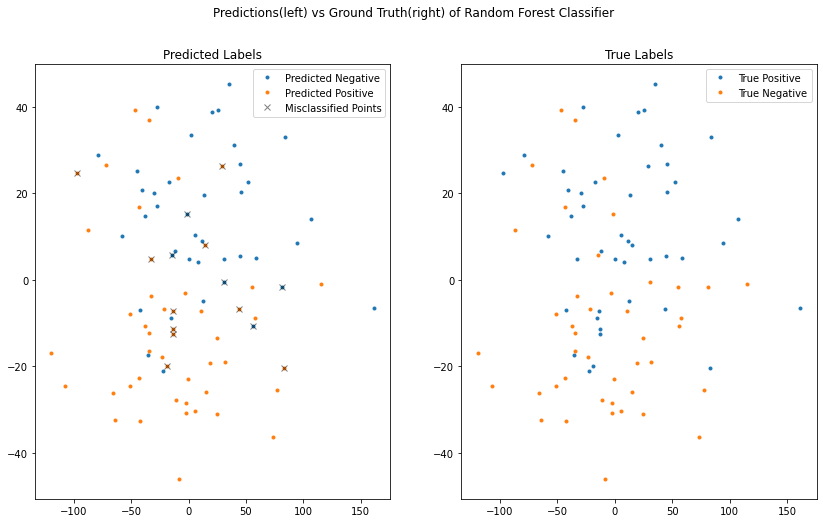

In [51]:
# Random Forest
plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
plt.plot(X_test_pca[y_pred==0][:,0], X_test_pca[y_pred==0][:,1], '.', label='Predicted Negative')
plt.plot(X_test_pca[y_pred==1][:,0], X_test_pca[y_pred==1][:,1], '.', label='Predicted Positive')
plt.plot(X_test_pca[y_pred!=y_test][:,0], X_test_pca[y_pred!=y_test][:,1], 'x', color='black', alpha=0.5, label='Misclassified Points')
plt.legend()
plt.title('Predicted Labels')
plt.subplot(1,2,2)
plt.plot(X_test_pca[y_test==0][:,0], X_test_pca[y_test==0][:,1], '.', label='True Positive')
plt.plot(X_test_pca[y_test==1][:,0], X_test_pca[y_test==1][:,1], '.', label='True Negative')
plt.legend()
plt.title('True Labels')
plt.suptitle('Predictions(left) vs Ground Truth(right) of Random Forest Classifier')

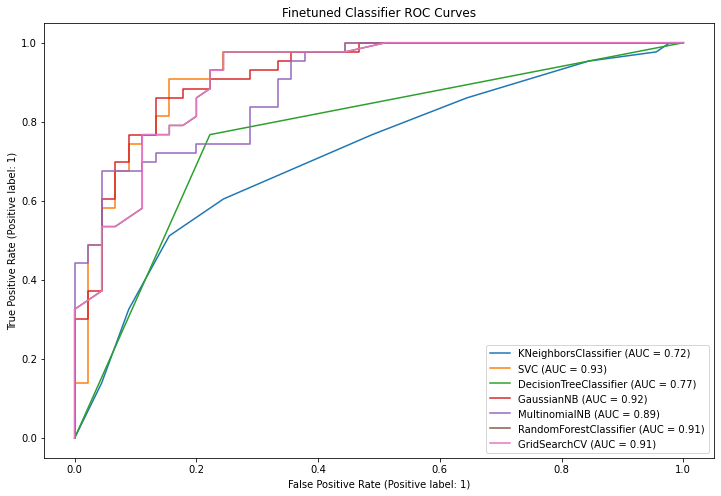

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
plt.title('Finetuned Classifier ROC Curves')
rcd = RocCurveDisplay
for i in range(len(best_classifers_performance)):
    rcd.from_estimator(best_classifers_performance[i][2], X_test, y_test, ax=ax)

rcd.from_estimator(clf, X_test, y_test, ax=ax)
plt.savefig('Best Classifiers ROC with Random Forest.png', facecolor='white', transparent=False)

# Ensemble of the Best Hypertuned Classifiers

In [61]:
best_classifers_performance.pop(-1)

('RandomForestClassifier',
 None,
 None,
 array([1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
        0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
        1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1],
       dtype=int8),
 array([0.83333333, 0.93333333, 0.9       , 0.79310345, 0.79310345,
        0.75862069, 0.96551724, 0.79310345, 0.86206897, 0.89655172]),
 0.8528735632183908)

In [63]:
from sklearn.ensemble import StackingClassifier

strat_k_fold = StratifiedKFold(n_splits=10, random_state=10, shuffle=True)

estimators = [(best_classifers_performance[1][0], best_classifers_performance[1][2]), (best_classifers_performance[5][0], best_classifers_performance[5][2])]

clf = StackingClassifier(estimators=estimators, final_estimator= None)
clf.fit(X_train, y_train)
test_predictions = clf.predict(X_test)
cross_val_scores = cross_val_score(clf, X, y, cv=strat_k_fold, scoring='accuracy')
print(f'Average Cross Validation Score: {cross_val_scores.mean()}')

best_classifers_performance.append(('StackingClassifier', None, None, test_predictions, cross_val_scores, cross_val_scores.mean()))


Average Cross Validation Score: 0.8528735632183908


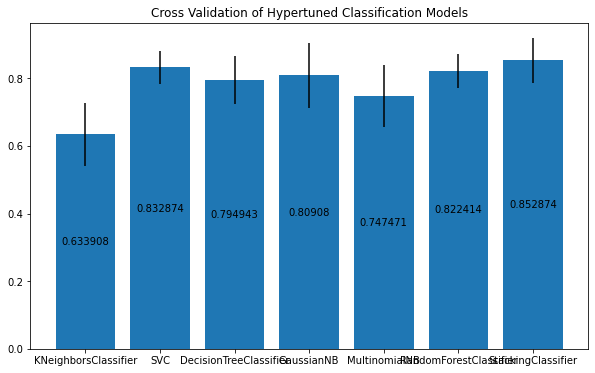

In [64]:
#visualize accuracy models
plt.figure(figsize = (10,6))
bars = sns.barplot(x = [best_classifers_performance[i][0] for i in range(len(best_classifers_performance))], y = [best_classifers_performance[i][5] for i in range(len(best_classifers_performance))], color = "blue")
x_errb = [i for i in range(len(best_classifers_performance))]
y_errb = [best_classifers_performance[i][5] for i in range(len(best_classifers_performance))]
y_errb_err = [best_classifers_performance[i][4].std() for i in range(len(best_classifers_performance))]
bars = plt.bar(x_errb, y_errb, yerr=y_errb_err)
plt.xticks(x_errb, labels=[best_classifers_performance[i][0] for i in range(len(best_classifers_performance))])
plt.bar_label(bars, label_type='center')

plt.title('Cross Validation of Hypertuned Classification Models')
plt.savefig('Best Classifiers Performance with Ensemble.png', facecolor='white', transparent=False)
plt.show()

# Finding Common Errors Among Hypertuned Classifiers

In [54]:
from collections import Counter
wrong_idxs_counts = Counter()

for i in range(len(best_classifers_performance)):
    wrong_arg = best_classifers_performance[i][3]!=y_test
    wrong_idx = np.where(wrong_arg)[0]
    wrong_idxs_counts.update(wrong_idx)

hard_examples = [i[0] for i in wrong_idxs_counts.most_common()[:15]]
hard_examples

[21, 26, 41, 52, 54, 69, 20, 48, 18, 34, 39, 13, 27, 62, 74]

In [55]:
df_errs = df.copy(True)
df_errs.iloc[hard_examples, -1] = 2

## Pairplots of Errors in All Classifers

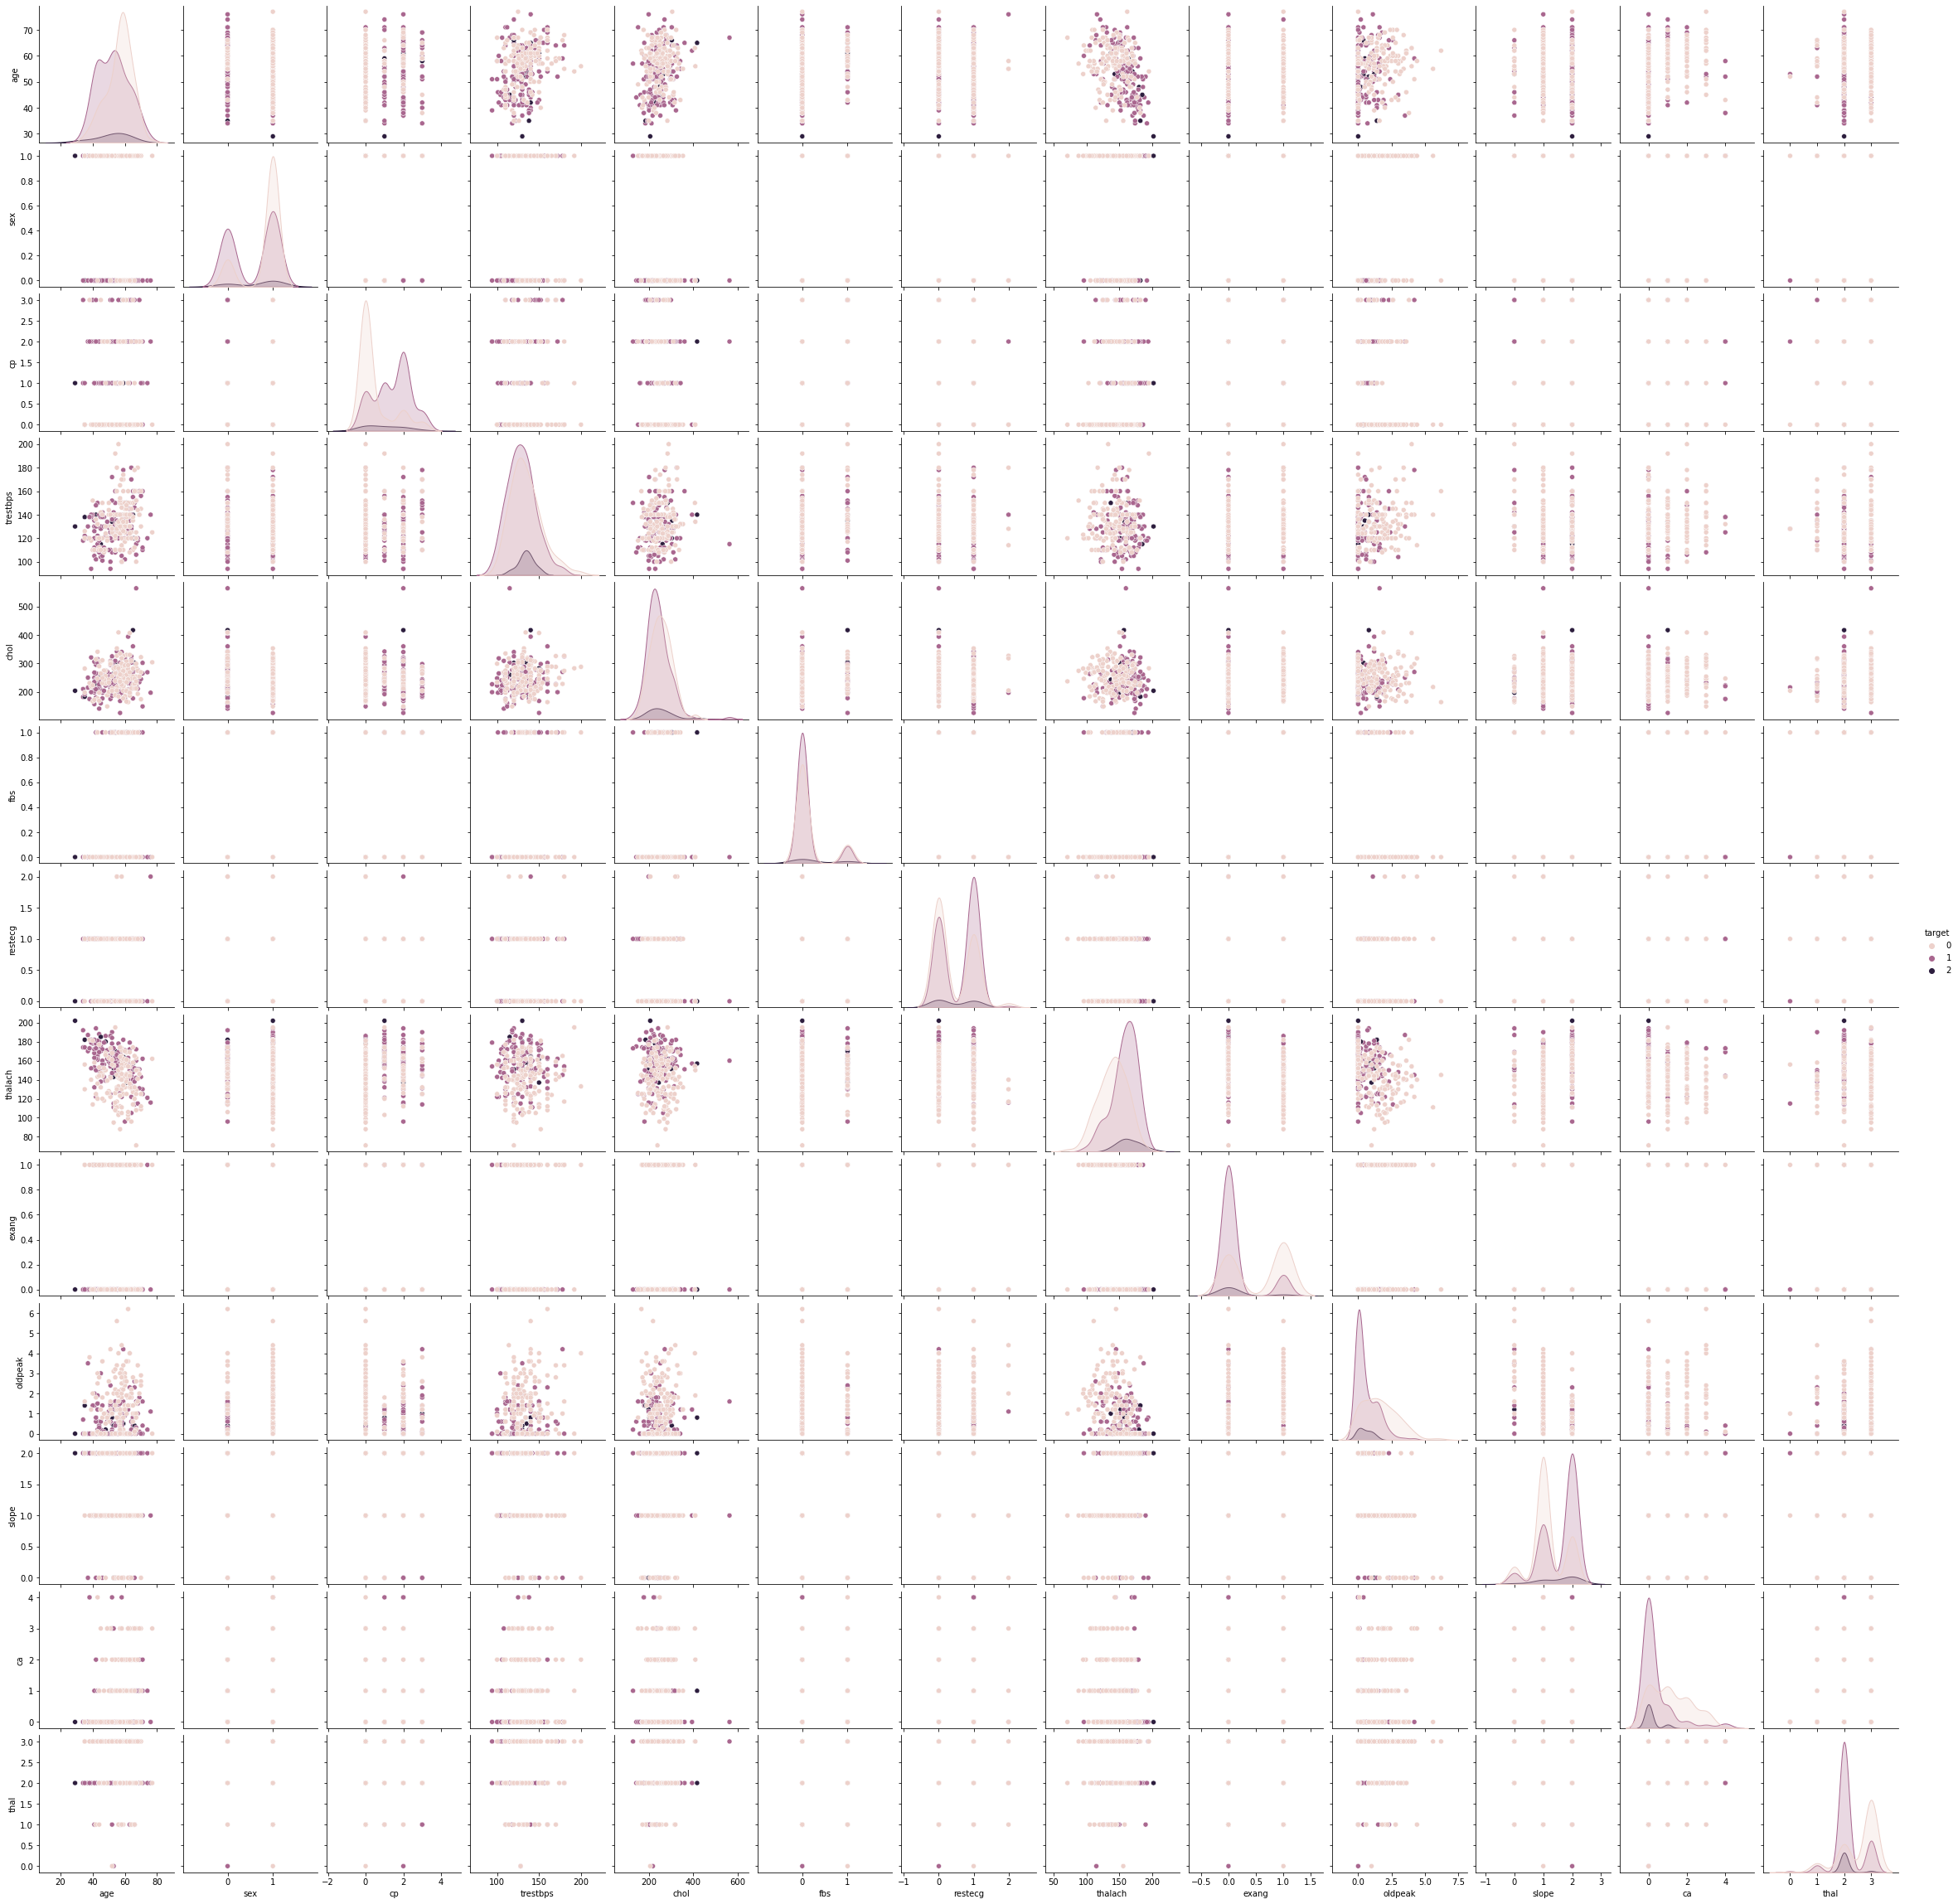

In [56]:
sns.pairplot(df_errs, hue='target')